# Diabetes Classification

## Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import missingno as msno
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from tabulate import tabulate


## Basic Exploratory Data Analysis (EDA)

In [2]:
df = pd.read_csv(r"C:\Users\henry\Desktop\academic\stat 4011\diabetes.csv")

In [3]:
#Basic EDA, dataset details
df.head()
df.info(verbose=True)
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


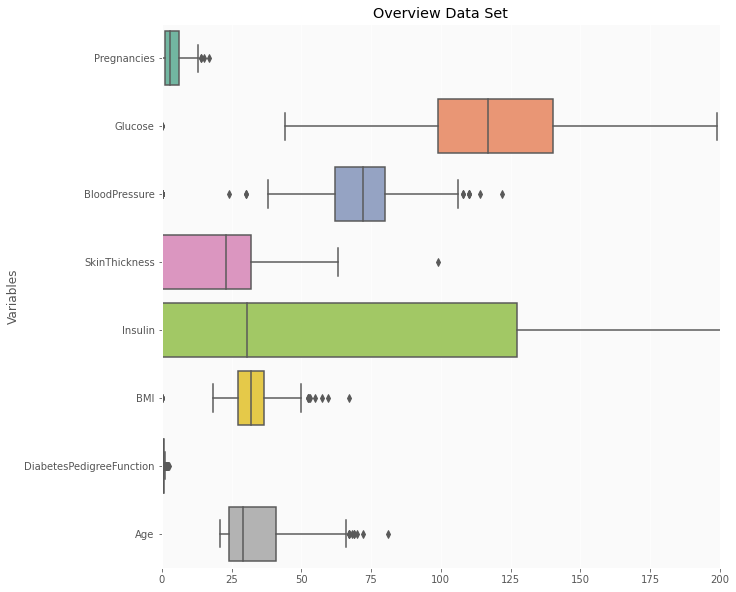

In [4]:
#Boxplot of Input variables
plt.style.use('ggplot') # Using ggplot2 style visuals 

f, ax = plt.subplots(figsize=(10, 10))

ax.set_facecolor('#fafafa')
ax.set(xlim=(-.05, 200))
plt.ylabel('Variables')
plt.title("Overview Data Set")
x = df.drop(["Outcome"] , axis = 1)
ax = sns.boxplot(data = x, 
  orient = 'h', 
  palette = 'Set2')

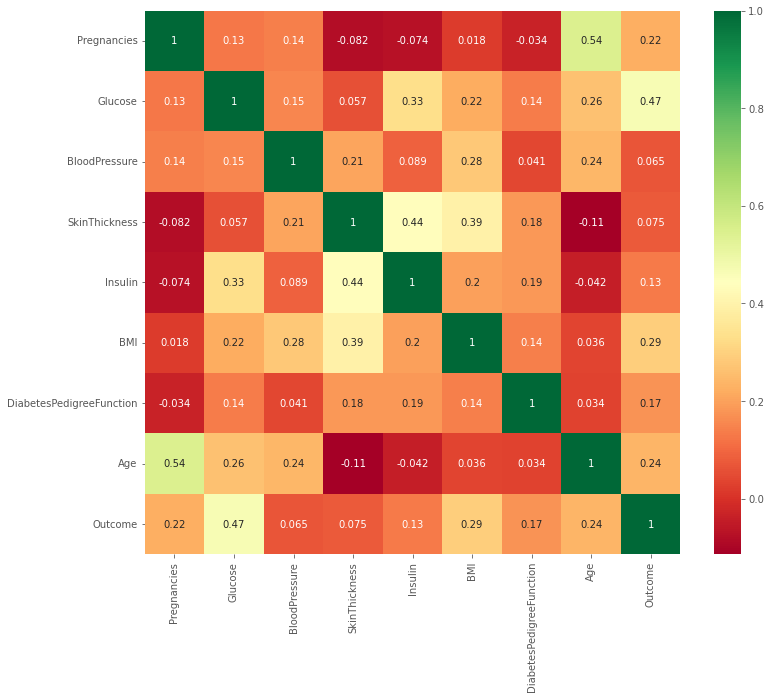

In [5]:
#Heatmap for data
plt.figure(figsize=(12,10))  # on this line I just set the size of figure to 12 by 10.
p=sns.heatmap(df.corr(), annot=True,cmap ='RdYlGn')  # seaborn has very simple solution for heatmap

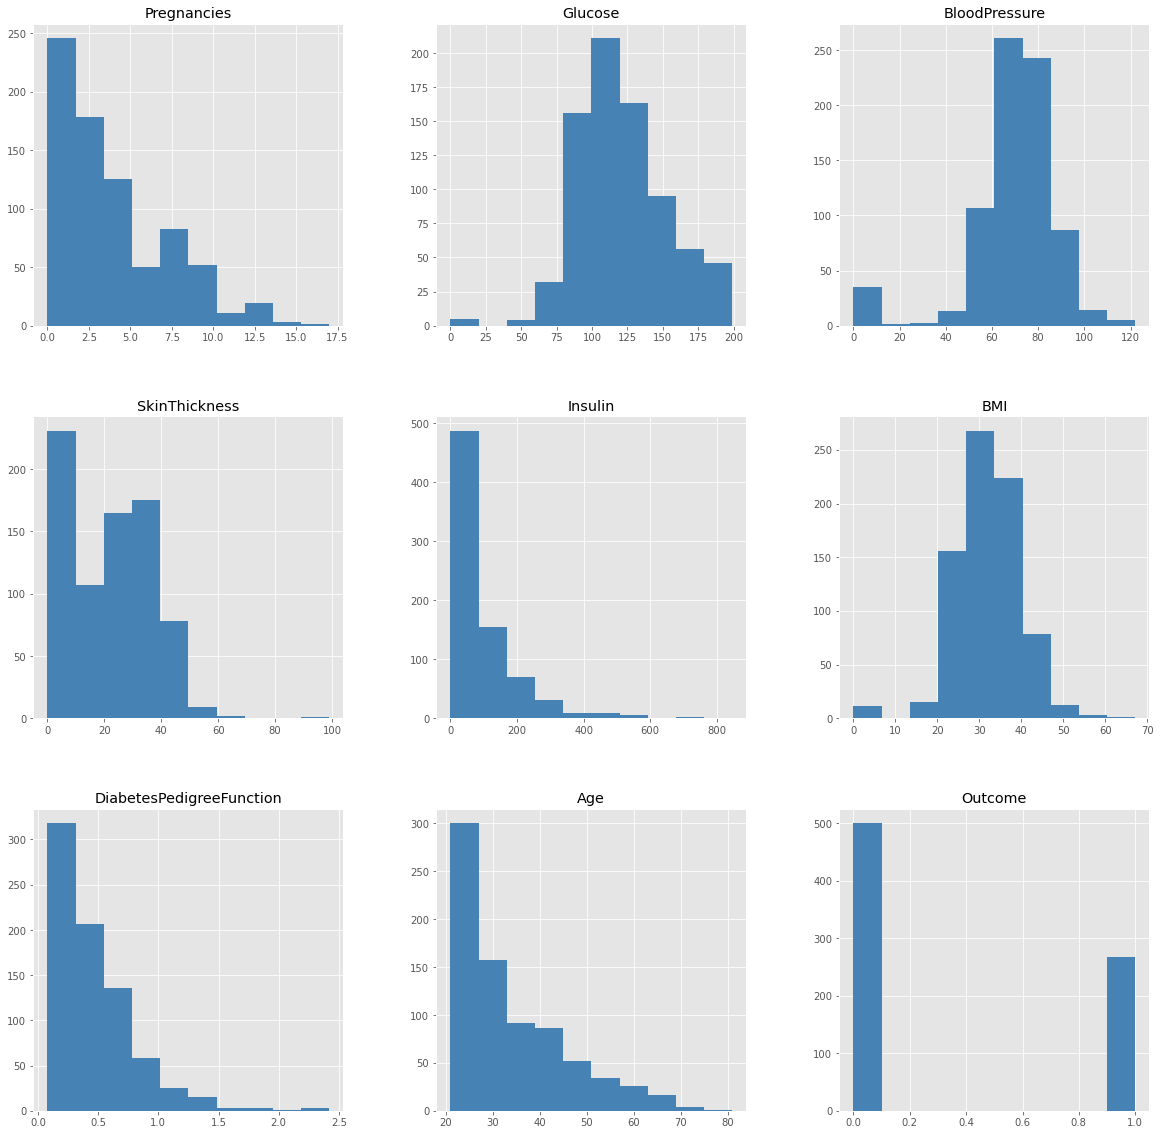

In [6]:
#Data display before cleaning
p = df.hist(figsize = (20,20),color = "steelblue")

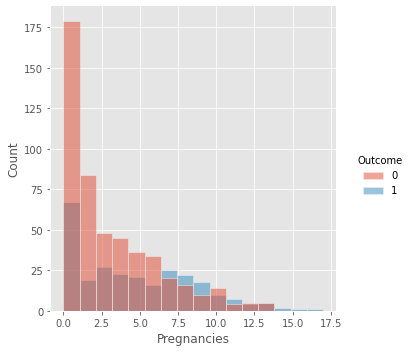

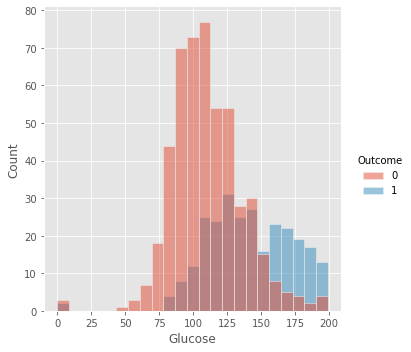

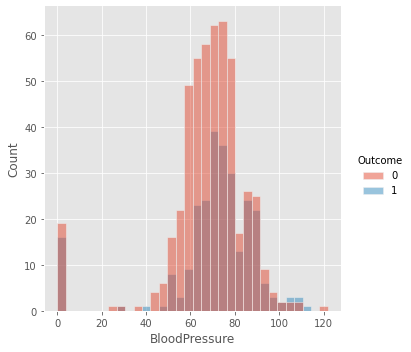

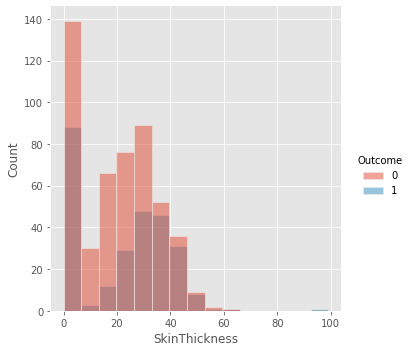

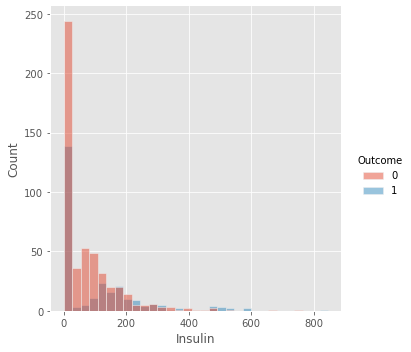

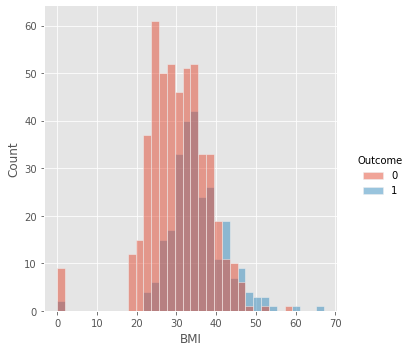

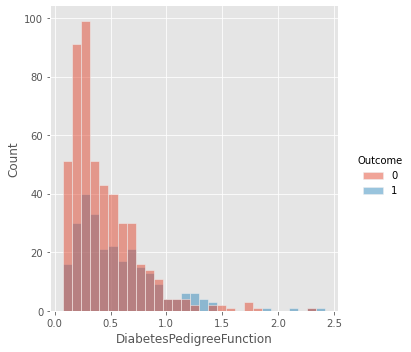

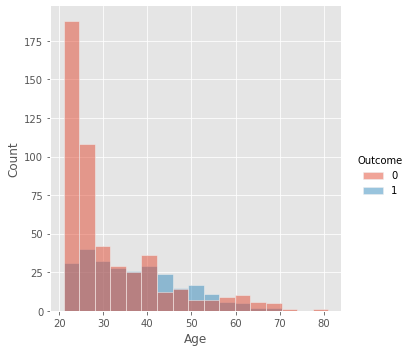

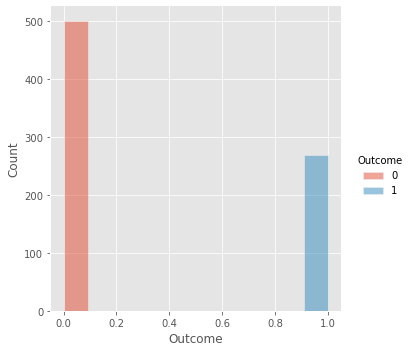

In [7]:
#Data display by mapping Outcome variables to different color
for i in range(8):
    sns.displot(data=df,x= df.columns[i],hue="Outcome")
sns.displot(data=df,x= df.columns[8],hue="Outcome",kind="hist")

In [8]:
#Checking for imbalance data
df.Outcome.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [9]:
#Outliers Detection 
def out_std(df,column):
    global lower,upper
    # calculate the mean and standard deviation of the data frame
    mean, sd = df[column].mean(), df[column].std()
    # calculate the cutoff value
    cut_off = sd * 3
    # calculate the lower and upper bound value
    lower, upper = mean - cut_off, mean + cut_off
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > upper]
    df2 = df[df[column] < lower]
    return print('{0: <25}'.format(column), df1.shape[0]+ df2.shape[0])

In [10]:
print("Outliers Detection")
for i in range(8):
    out_std(df,df.columns[i])

Outliers Detection
Pregnancies               4
Glucose                   5
BloodPressure             35
SkinThickness             1
Insulin                   18
BMI                       14
DiabetesPedigreeFunction  11
Age                       5


## Data Cleaning

In [11]:
#Replacing impossible zeros with NaN
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0, np.NaN)

In [12]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

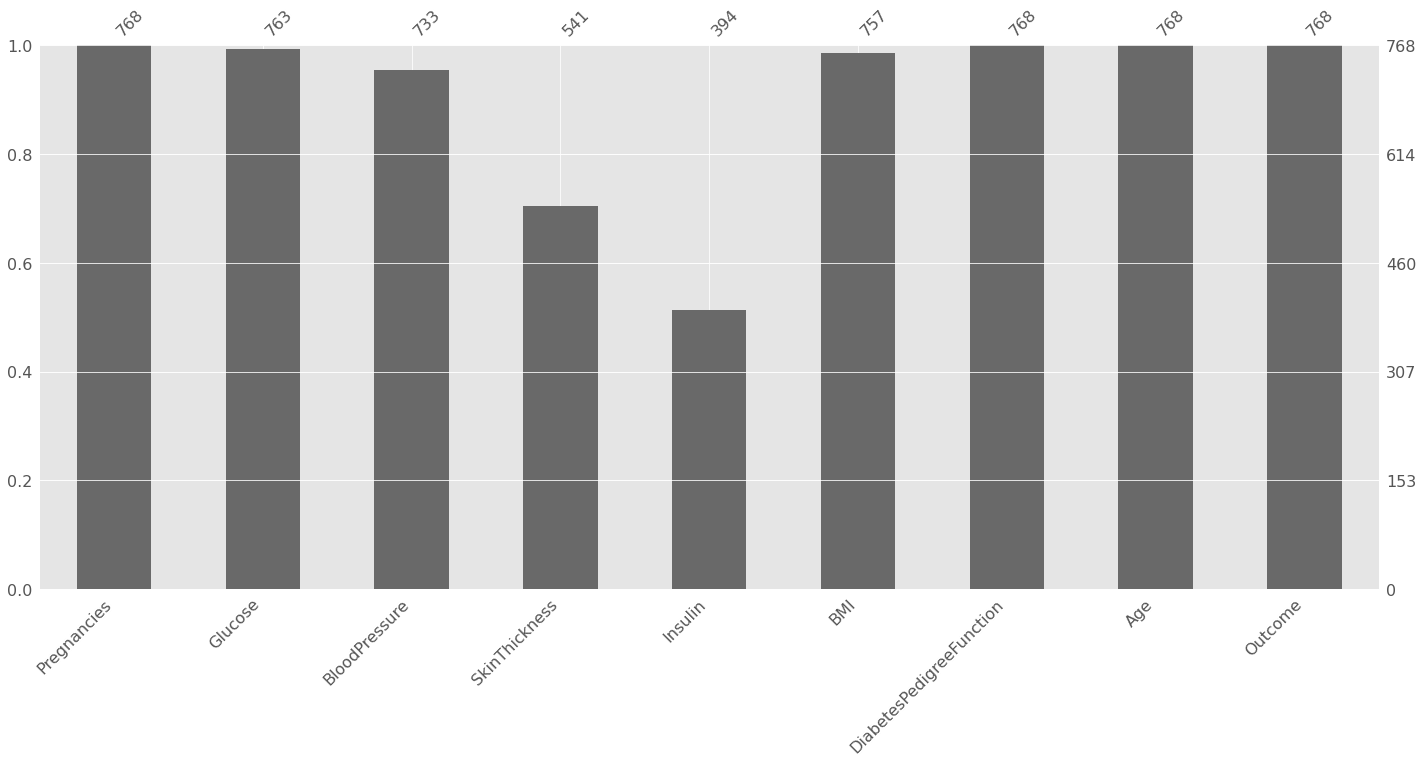

In [13]:
import missingno as msno
msno.bar(df);

In [14]:
#Using median to replace those NaN
def median_target(var):    
    temp = df[df[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

columns = df.columns
columns = columns.drop("Outcome")

for col in columns:
    df.loc[(df['Outcome'] == 0 ) & (df[col].isnull()), col] = median_target(col)[col][0]
    df.loc[(df['Outcome'] == 1 ) & (df[col].isnull()), col] = median_target(col)[col][1]

In [15]:
#Log tranfromation on Insulin, DiabetesPedigreeFunction, and Age
df['Insulin'] = np.log(df['Insulin'])
df['DiabetesPedigreeFunction'] = np.log(df['DiabetesPedigreeFunction'])
df['Age'] = np.log(df['Age'])


In [16]:
# Applying SMOTE
y = df["Outcome"]
x = df.drop(["Outcome"] , axis = 1)

sm = SMOTE(random_state = 4011)
x_balance, y_balance = sm.fit_resample(x, y)

y_balance.value_counts()

1    500
0    500
Name: Outcome, dtype: int64

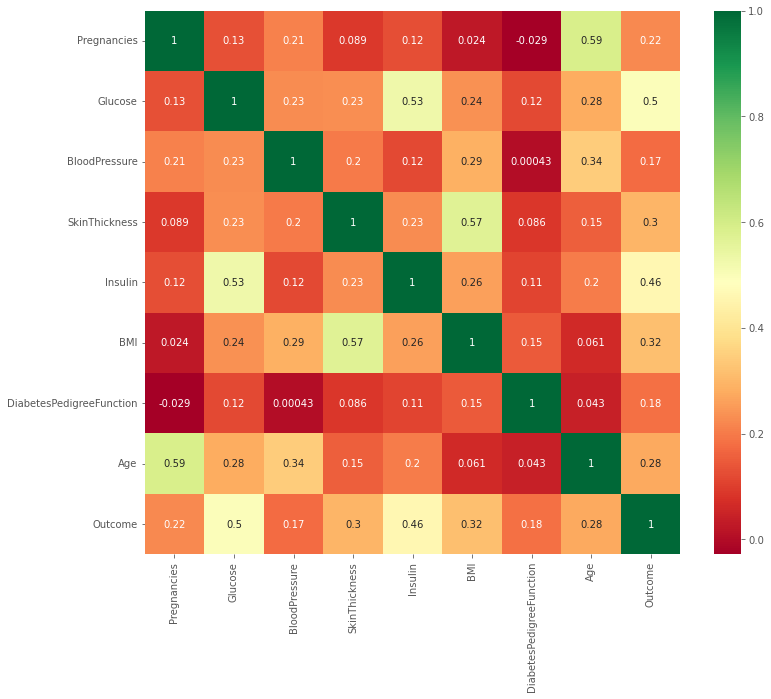

In [17]:
#Heatmap for cleaned data
plt.figure(figsize=(12,10))  # on this line I just set the size of figure to 12 by 10.
p=sns.heatmap(df.corr(), annot=True,cmap ='RdYlGn')  # seaborn has very simple solution for heatmap

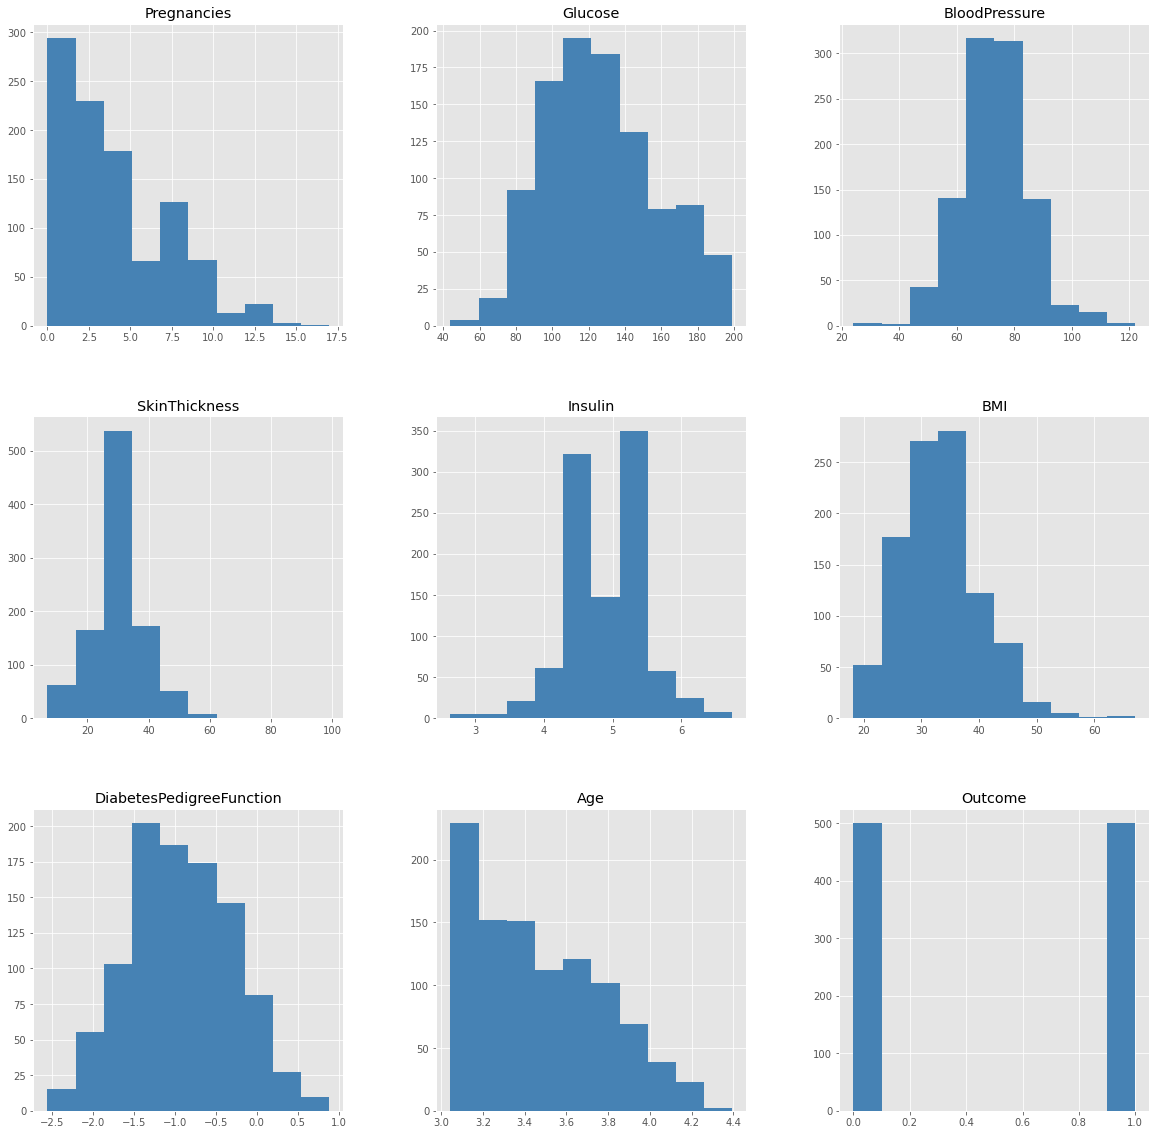

In [18]:
#Data display after cleaning
new_df = x_balance.assign(Outcome = y_balance)
p = new_df.hist(figsize = (20,20),color = "steelblue")

In [19]:
#Outliers Detection After Cleaning
print("Outliers Detection")
for i in range(8):
    out_std(df,df.columns[i])

Outliers Detection
Pregnancies               4
Glucose                   0
BloodPressure             8
SkinThickness             4
Insulin                   13
BMI                       5
DiabetesPedigreeFunction  0
Age                       0


In [14]:
# split train set and test set 
def split_train_test(data, test_ratio): # define a function to split train set and test set
    np.random.seed(4011)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]
train_set_X, test_set_X = split_train_test(x_balance, 0.2) # find the train set and test set of X
train_set_Y, test_set_Y = split_train_test(y_balance, 0.2) # find the train set and test set of Y
print(train_set_X.shape)
print(test_set_X.shape)
print(train_set_Y.shape)
print(test_set_Y.shape)

(800, 8)
(200, 8)
(800,)
(200,)


In [15]:
# Normalizes all features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_set_X = scaler.fit_transform(train_set_X)
test_set_X = scaler.transform(test_set_X)

# SVM

In [16]:
#SVM
svm_clf =SVC()
param_distribs = {
    'C': range(1,100),
    'gamma': np.arange(0.01,1,0.05),
    'kernel': ['rbf', 'poly', 'sigmoid']
}

grid_search = RandomizedSearchCV(estimator = svm_clf, param_distributions = param_distribs, 
                          cv = 10, n_iter=50,scoring='f1',n_jobs = -1, verbose = 2) 

grid_search.fit(train_set_X,train_set_Y)
svm_best_params = grid_search.best_params_ #Hyperparameter Tuning
print(svm_best_params)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
{'kernel': 'rbf', 'gamma': 0.6100000000000001, 'C': 99}


In [17]:
svm_clf = SVC(**svm_best_params)

svm_clf.fit(train_set_X,train_set_Y)

SVC(C=99, gamma=0.6100000000000001)

In [18]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = cross_val_predict(clf, X_train,y_train, cv=10) 
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = cross_val_predict(clf, X_test,y_test, cv=10) 
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [19]:
#Error Analysis (SVM)
print_score(svm_clf, train_set_X, train_set_Y, test_set_X, test_set_Y, train=True) 
print_score(svm_clf, train_set_X, train_set_Y, test_set_X, test_set_Y, train=False)

Train Result:
Accuracy Score: 87.00%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.890667    0.851765      0.87    0.871216      0.871070
recall       0.841310    0.898263      0.87    0.869786      0.870000
f1-score     0.865285    0.874396      0.87    0.869841      0.869875
support    397.000000  403.000000      0.87  800.000000    800.000000
_______________________________________________
Confusion Matrix: 
 [[334  63]
 [ 41 362]]

Test Result:
Accuracy Score: 81.00%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.828283   0.792079      0.81    0.810181      0.810724
recall       0.796117   0.824742      0.81    0.810429      0.810000
f1-score     0.811881   0.808081      0.81    0.809981      0.810038
support    103.000000  97.000000      0.81  200.000000    200.00000

In [20]:
def plot_roc_curve(train_fpr , trian_tpr , test_fpr , test_tpr ,  model_name):
    figure, axis = plt.subplots(1, 2)
    axis[0].plot(train_fpr, trian_tpr, linewidth=3)
    axis[0].plot([0, 1], [0, 1], 'k--')
    axis[0].axis([0, 1, 0, 1])
    axis[0].set_xlabel('False Positive Rate')
    axis[0].set_ylabel('True Positive Rate')
    axis[0].set_title(model_name + " (training) ROC curve")
    
    axis[1].plot(test_fpr, test_tpr, linewidth=3)
    axis[1].plot([0, 1], [0, 1], 'k--')
    axis[1].axis([0, 1, 0, 1])
    axis[1].set_xlabel('False Positive Rate')
    axis[1].set_ylabel('True Positive Rate')
    axis[1].set_title(model_name + " (testing) ROC curve")
    

In [21]:
Y_scores_train = cross_val_predict(svm_clf,train_set_X,train_set_Y, cv=10, method="decision_function") # roc 
train_fpr, trian_tpr, thresholds = roc_curve(train_set_Y, Y_scores_train) # find fpr and tpr and all thresholds

Y_scores_test = cross_val_predict(svm_clf,test_set_X,test_set_Y, cv=10, method="decision_function") # roc 
test_fpr, test_tpr, thresholds = roc_curve(test_set_Y, Y_scores_test) # find fpr and tpr and all thresholds

Aoc of Svm (training)0.9045133788775619
Aoc of Svm (testing)0.8608747873085778


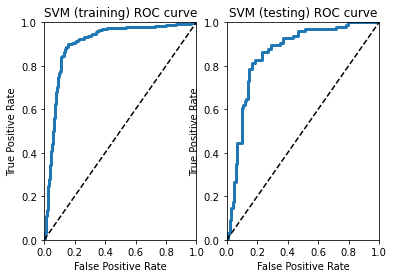

In [22]:
plot_roc_curve(train_fpr , trian_tpr , test_fpr , test_tpr ,  "SVM")
print("Aoc of Svm (training)" + str (roc_auc_score(train_set_Y, Y_scores_train)))
print("Aoc of Svm (testing)" + str (roc_auc_score(test_set_Y, Y_scores_test)))

# XGB

In [23]:
# XGB
xgb = GradientBoostingClassifier(random_state = 4011)

xgb_params = {
    "learning_rate": [0.01,0.05, 0.1, 0.2, 0.3],
    "min_samples_split": np.linspace(0.1, 0.5, 10),
    "max_depth":[3, 5, 6, 10, 15, 20],
    "subsample":np.arange(0.5, 1.0, 0.1),
    "n_estimators": [100, 500, 1000]}

In [24]:
xgb_cv_model  = RandomizedSearchCV(xgb,xgb_params, cv = 10, n_jobs = -1, verbose = 2,scoring='f1',n_iter=50).fit(train_set_X,train_set_Y)
xgb_best_params_ = xgb_cv_model.best_params_
print(xgb_best_params_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
{'subsample': 0.8999999999999999, 'n_estimators': 1000, 'min_samples_split': 0.14444444444444446, 'max_depth': 10, 'learning_rate': 0.01}


In [25]:
xgb_tuned = GradientBoostingClassifier(**xgb_best_params_)

xgb_tuned.fit(train_set_X,train_set_Y)

GradientBoostingClassifier(learning_rate=0.01, max_depth=10,
                           min_samples_split=0.14444444444444446,
                           n_estimators=1000, subsample=0.8999999999999999)

In [26]:
#Error Analysis (XGB)
print_score(xgb_tuned, train_set_X, train_set_Y, test_set_X, test_set_Y, train=True) 
print_score(xgb_tuned, train_set_X, train_set_Y, test_set_X, test_set_Y, train=False)

Train Result:
Accuracy Score: 90.12%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.909794    0.893204   0.90125    0.901499      0.901437
recall       0.889169    0.913151   0.90125    0.901160      0.901250
f1-score     0.899363    0.903067   0.90125    0.901215      0.901229
support    397.000000  403.000000   0.90125  800.000000    800.000000
_______________________________________________
Confusion Matrix: 
 [[353  44]
 [ 35 368]]

Test Result:
Accuracy Score: 86.00%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.871287   0.848485      0.86    0.859886      0.860228
recall       0.854369   0.865979      0.86    0.860174      0.860000
f1-score     0.862745   0.857143      0.86    0.859944      0.860028
support    103.000000  97.000000      0.86  200.000000    200.00000

Aoc of XGB (training)0.9655355613753273
Aoc of XGB (testing)0.9383445100590532


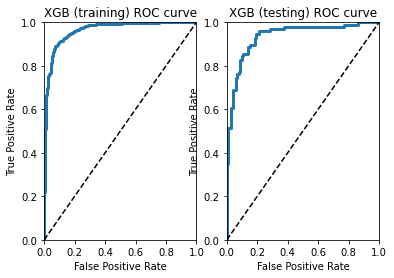

In [27]:
Y_scores_train = cross_val_predict(xgb_tuned,train_set_X,train_set_Y, cv=10, method="decision_function") # roc 
train_fpr, trian_tpr, thresholds = roc_curve(train_set_Y, Y_scores_train) # find fpr and tpr and all thresholds

Y_scores_test = cross_val_predict(xgb_tuned,test_set_X,test_set_Y, cv=10, method="decision_function") # roc 
test_fpr, test_tpr, thresholds = roc_curve(test_set_Y, Y_scores_test) # find fpr and tpr and all thresholds

plot_roc_curve(train_fpr , trian_tpr , test_fpr , test_tpr ,  "XGB")
print("Aoc of XGB (training)" + str (roc_auc_score(train_set_Y, Y_scores_train)))
print("Aoc of XGB (testing)" + str (roc_auc_score(test_set_Y, Y_scores_test)))

# Random Forest

In [28]:

rf_clf = RandomForestClassifier(random_state=4011)

n_estimators = [int(x) for x in np.linspace(start=10, stop=1000, num=10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 100, num=10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators, 'max_features': max_features,
               'max_depth': max_depth, 'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}
rf_cv = RandomizedSearchCV(estimator=rf_clf, scoring='f1',param_distributions=random_grid, n_iter=50, cv=10, 
                               verbose=2, n_jobs=-1)

rf_cv.fit(train_set_X, train_set_Y)
rf_best_params = rf_cv.best_params_
print(f"Best paramters: {rf_best_params})")

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best paramters: {'n_estimators': 450, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': False})


In [29]:
rf_clf = RandomForestClassifier(**rf_best_params)
rf_clf.fit(train_set_X, train_set_Y)


RandomForestClassifier(bootstrap=False, max_depth=100, n_estimators=450)

In [30]:
print_score(rf_clf, train_set_X, train_set_Y, test_set_X, test_set_Y, train=True)
print_score(rf_clf, train_set_X, train_set_Y, test_set_X, test_set_Y, train=False)

Train Result:
Accuracy Score: 90.00%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.934247    0.871264       0.9    0.902755      0.902519
recall       0.858942    0.940447       0.9    0.899694      0.900000
f1-score     0.895013    0.904535       0.9    0.899774      0.899810
support    397.000000  403.000000       0.9  800.000000    800.000000
_______________________________________________
Confusion Matrix: 
 [[341  56]
 [ 24 379]]

Test Result:
Accuracy Score: 90.00%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy  macro avg  weighted avg
precision    0.919192   0.881188       0.9    0.90019       0.90076
recall       0.883495   0.917526       0.9    0.90051       0.90000
f1-score     0.900990   0.898990       0.9    0.89999       0.90002
support    103.000000  97.000000       0.9  200.00000     200.00000
___

Aoc of RF (training)0.964601133813777
Aoc of RF (testing)0.9452006806125514


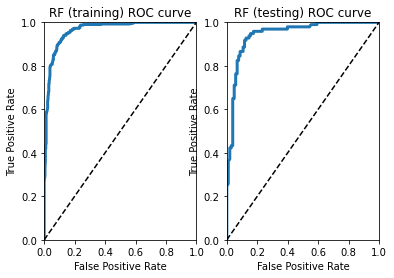

In [31]:
Y_scores_train = cross_val_predict(rf_clf,train_set_X,train_set_Y, cv=10, method="predict_proba") # roc 
Y_scores_train = Y_scores_train[:,1]

train_fpr, trian_tpr, thresholds = roc_curve(train_set_Y, Y_scores_train) # find fpr and tpr and all thresholds

Y_scores_test = cross_val_predict(rf_clf,test_set_X,test_set_Y, cv=10, method="predict_proba") # roc 
Y_scores_test = Y_scores_test[:,1]
test_fpr, test_tpr, thresholds = roc_curve(test_set_Y, Y_scores_test) # find fpr and tpr and all thresholds

plot_roc_curve(train_fpr , trian_tpr , test_fpr , test_tpr ,  "RF")
print("Aoc of RF (training)" + str (roc_auc_score(train_set_Y, Y_scores_train)))
print("Aoc of RF (testing)" + str (roc_auc_score(test_set_Y, Y_scores_test)))

# DecisionTree


In [32]:
dt_clf = DecisionTreeClassifier()

max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 100, num=10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

random_grid = {'max_features': max_features,
               'max_depth': max_depth, 'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

dt_cv = RandomizedSearchCV(estimator=dt_clf, scoring='f1',param_distributions=random_grid, n_iter=50, cv=10, 
                               verbose=2, n_jobs=-1)

dt_cv.fit(train_set_X, train_set_Y)
dt_best_params = dt_cv.best_params_
print(f"Best paramters: {dt_best_params})")

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best paramters: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 5})


In [33]:
dt_clf = DecisionTreeClassifier(**dt_best_params)
dt_clf.fit(train_set_X, train_set_Y)

DecisionTreeClassifier(max_depth=5, max_features='log2', min_samples_leaf=2,
                       min_samples_split=5)

In [34]:
print_score(dt_clf, train_set_X, train_set_Y, test_set_X, test_set_Y, train=True)
print_score(dt_clf, train_set_X, train_set_Y, test_set_X, test_set_Y, train=False)

Train Result:
Accuracy Score: 85.88%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.879679    0.840376   0.85875    0.860027      0.859880
recall       0.828715    0.888337   0.85875    0.858526      0.858750
f1-score     0.853437    0.863691   0.85875    0.858564      0.858603
support    397.000000  403.000000   0.85875  800.000000    800.000000
_______________________________________________
Confusion Matrix: 
 [[329  68]
 [ 45 358]]

Test Result:
Accuracy Score: 78.50%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.758621   0.821429     0.785    0.790025      0.789083
recall       0.854369   0.711340     0.785    0.782855      0.785000
f1-score     0.803653   0.762431     0.785    0.783042      0.783660
support    103.000000  97.000000     0.785  200.000000    200.00000

Aoc of DT (training)0.912473201617591
Aoc of DT (testing)0.8857972174957461


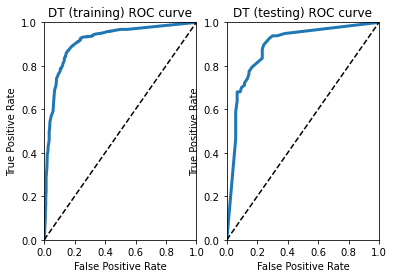

In [35]:
Y_scores_train = cross_val_predict(dt_clf,train_set_X,train_set_Y, cv=10, method="predict_proba") # roc 
Y_scores_train = Y_scores_train[:,1]

train_fpr, trian_tpr, thresholds = roc_curve(train_set_Y, Y_scores_train) # find fpr and tpr and all thresholds

Y_scores_test = cross_val_predict(dt_clf,test_set_X,test_set_Y, cv=10, method="predict_proba") # roc 
Y_scores_test = Y_scores_test[:,1]
test_fpr, test_tpr, thresholds = roc_curve(test_set_Y, Y_scores_test) # find fpr and tpr and all thresholds

plot_roc_curve(train_fpr , trian_tpr , test_fpr , test_tpr ,  "DT")
print("Aoc of DT (training)" + str (roc_auc_score(train_set_Y, Y_scores_train)))
print("Aoc of DT (testing)" + str (roc_auc_score(test_set_Y, Y_scores_test)))

# LogisticRegression


In [36]:
log_model = LogisticRegression().fit(train_set_X, train_set_Y)


cv_results = cross_validate(log_model,
                            train_set_X, train_set_Y,
                            cv=10,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"],
                            verbose=2, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [37]:
y_pred = log_model.predict(train_set_X)
print(classification_report(train_set_Y, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.80      0.82       397
           1       0.81      0.84      0.83       403

    accuracy                           0.82       800
   macro avg       0.82      0.82      0.82       800
weighted avg       0.82      0.82      0.82       800



In [38]:
print_score(log_model, train_set_X, train_set_Y, test_set_X, test_set_Y, train=True)
print_score(log_model, train_set_X, train_set_Y, test_set_X, test_set_Y, train=False)

Train Result:
Accuracy Score: 81.00%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.813299    0.806846      0.81    0.810073      0.810048
recall       0.801008    0.818859      0.81    0.809933      0.810000
f1-score     0.807107    0.812808      0.81    0.809957      0.809979
support    397.000000  403.000000      0.81  800.000000    800.000000
_______________________________________________
Confusion Matrix: 
 [[318  79]
 [ 73 330]]

Test Result:
Accuracy Score: 78.00%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.786408   0.773196      0.78    0.779802          0.78
recall       0.786408   0.773196      0.78    0.779802          0.78
f1-score     0.786408   0.773196      0.78    0.779802          0.78
support    103.000000  97.000000      0.78  200.000000        200.0

In [39]:
Y_scores_train = cross_val_predict(log_model,train_set_X,train_set_Y, cv=10, method="decision_function") # roc 
train_fpr, trian_tpr, thresholds = roc_curve(train_set_Y, Y_scores_train) # find fpr and tpr and all thresholds

Y_scores_test = cross_val_predict(log_model,test_set_X,test_set_Y, cv=10, method="decision_function") # roc 
test_fpr, test_tpr, thresholds = roc_curve(test_set_Y, Y_scores_test) # find fpr and tpr and all thresholds

Aoc of Logistic (training)0.874680450775356
Aoc of Logistic (testing)0.8623761385246722


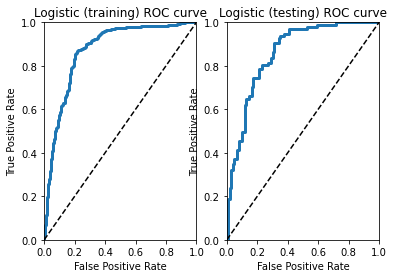

In [40]:
plot_roc_curve(train_fpr , trian_tpr , test_fpr , test_tpr ,  "Logistic")
print("Aoc of Logistic (training)" + str (roc_auc_score(train_set_Y, Y_scores_train)))
print("Aoc of Logistic (testing)" + str (roc_auc_score(test_set_Y, Y_scores_test)))

# Knn

In [41]:
knn = KNeighborsClassifier(1)

param_distributions = {'n_neighbors':np.arange(1,50),
                      'weights' : ['uniform','distance'],
                       'metric' : ['minkowski','euclidean','manhattan']
                    }
knn = KNeighborsClassifier()
knn_cv= RandomizedSearchCV(knn,param_distributions,cv=10,scoring='f1',n_iter=50, 
                               verbose=2, n_jobs=-1)

knn_cv.fit(train_set_X, train_set_Y)

knn_best_params = knn_cv.best_params_
print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best Score:0.8863014969802452
Best Parameters: {'weights': 'distance', 'n_neighbors': 23, 'metric': 'manhattan'}


In [42]:
knn_clf = KNeighborsClassifier(**knn_best_params)
knn_clf.fit(train_set_X, train_set_Y)

KNeighborsClassifier(metric='manhattan', n_neighbors=23, weights='distance')

In [43]:
print_score(knn_clf, train_set_X, train_set_Y, test_set_X, test_set_Y, train=True)
print_score(knn_clf, train_set_X, train_set_Y, test_set_X, test_set_Y, train=False)

Train Result:
Accuracy Score: 87.75%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.935860    0.833698    0.8775    0.884779      0.884396
recall       0.808564    0.945409    0.8775    0.876987      0.877500
f1-score     0.867568    0.886047    0.8775    0.876807      0.876876
support    397.000000  403.000000    0.8775  800.000000    800.000000
_______________________________________________
Confusion Matrix: 
 [[321  76]
 [ 22 381]]

Test Result:
Accuracy Score: 82.00%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.885057   0.769912      0.82    0.827484      0.829212
recall       0.747573   0.896907      0.82    0.822240      0.820000
f1-score     0.810526   0.828571      0.82    0.819549      0.819278
support    103.000000  97.000000      0.82  200.000000    200.00000

Aoc of Knn (training)0.9421686219849866
Aoc of Knn (testing)0.90651586427785


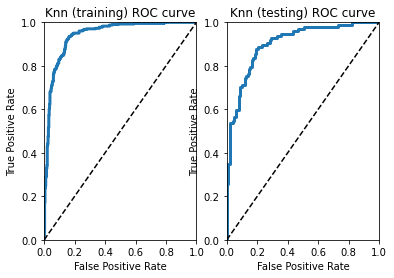

In [44]:
Y_scores_train = cross_val_predict(knn_clf,train_set_X,train_set_Y, cv=10, method="predict_proba") # roc 
Y_scores_train = Y_scores_train[:,1]

train_fpr, trian_tpr, thresholds = roc_curve(train_set_Y, Y_scores_train) # find fpr and tpr and all thresholds

Y_scores_test = cross_val_predict(knn_clf,test_set_X,test_set_Y, cv=10, method="predict_proba") # roc 
Y_scores_test = Y_scores_test[:,1]
test_fpr, test_tpr, thresholds = roc_curve(test_set_Y, Y_scores_test) # find fpr and tpr and all thresholds

plot_roc_curve(train_fpr , trian_tpr , test_fpr , test_tpr ,  "Knn")
print("Aoc of Knn (training)" + str (roc_auc_score(train_set_Y, Y_scores_train)))
print("Aoc of Knn (testing)" + str (roc_auc_score(test_set_Y, Y_scores_test)))

# Compare different Model

(0.0, 1.0, 0.0, 1.0)

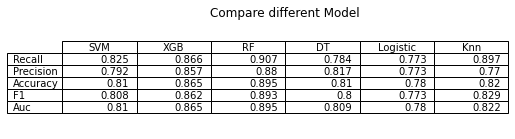

In [45]:
# base on testing data 

test_pred_Y_Svm = cross_val_predict(svm_clf, test_set_X,test_set_Y, cv=10) 
test_pred_Y_Xgb = cross_val_predict(xgb_tuned, test_set_X,test_set_Y, cv=10) 
test_pred_Y_RF = cross_val_predict(rf_clf, test_set_X,test_set_Y, cv=10) 
test_pred_Y_DT = cross_val_predict(dt_clf, test_set_X,test_set_Y, cv=10) 
test_pred_Y_Logistic = cross_val_predict(log_model, test_set_X,test_set_Y, cv=10) 
test_pred_Y_Knn = cross_val_predict(knn_clf, test_set_X,test_set_Y, cv=10) 



rows_names = ["Recall" , "Precision" , "Accuracy" , "F1" , "Auc"]
my_frame = pd.DataFrame(data={'SVM':[recall_score(test_set_Y, test_pred_Y_Svm),precision_score(test_set_Y, test_pred_Y_Svm),accuracy_score(test_set_Y, test_pred_Y_Svm),f1_score(test_set_Y, test_pred_Y_Svm),roc_auc_score(test_set_Y, test_pred_Y_Svm)],
                              'XGB':[recall_score(test_set_Y, test_pred_Y_Xgb),precision_score(test_set_Y, test_pred_Y_Xgb),accuracy_score(test_set_Y, test_pred_Y_Xgb),f1_score(test_set_Y, test_pred_Y_Xgb),roc_auc_score(test_set_Y, test_pred_Y_Xgb)],
                              'RF':[recall_score(test_set_Y, test_pred_Y_RF),precision_score(test_set_Y, test_pred_Y_RF),accuracy_score(test_set_Y, test_pred_Y_RF),f1_score(test_set_Y, test_pred_Y_RF),roc_auc_score(test_set_Y, test_pred_Y_RF)],
                              'DT':[recall_score(test_set_Y, test_pred_Y_DT),precision_score(test_set_Y, test_pred_Y_DT),accuracy_score(test_set_Y, test_pred_Y_DT),f1_score(test_set_Y, test_pred_Y_DT),roc_auc_score(test_set_Y, test_pred_Y_DT)],
                              'Logistic':[recall_score(test_set_Y, test_pred_Y_Logistic),precision_score(test_set_Y, test_pred_Y_Logistic),accuracy_score(test_set_Y, test_pred_Y_Logistic),f1_score(test_set_Y, test_pred_Y_Logistic),roc_auc_score(test_set_Y, test_pred_Y_Logistic)],
                              'Knn':[recall_score(test_set_Y, test_pred_Y_Knn),precision_score(test_set_Y, test_pred_Y_Knn),accuracy_score(test_set_Y, test_pred_Y_Knn),f1_score(test_set_Y, test_pred_Y_Knn),roc_auc_score(test_set_Y, test_pred_Y_Knn)]
                                 })

my_frame = my_frame.round(3)
fig = plt.figure(figsize = (8, 2))
ax = fig.add_subplot(111)

ax.table(cellText = my_frame.values,
          rowLabels = rows_names,
          colLabels = my_frame.columns,
          loc = "center"
         )
ax.set_title("Compare different Model")

ax.axis("off") 

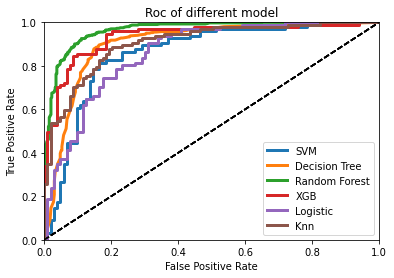

In [46]:
# compare roc of different model (base on testing data )

def plot_roc_curve(fpr, tpr, label=None):
 plt.plot(fpr, tpr, linewidth=3, label=label)
 plt.plot([0, 1], [0, 1], 'k--')
 plt.axis([0, 1, 0, 1])
 plt.xlabel('False Positive Rate')
 plt.ylabel('True Positive Rate')

Y_scores_svm = cross_val_predict(svm_clf,test_set_X,test_set_Y, cv=10, method="decision_function") 
fpr_svm, tpr_svm, thresholds_svm = roc_curve(test_set_Y, Y_scores_svm) 
plot_roc_curve(fpr_svm, tpr_svm, "SVM")
plt.legend(loc="lower right")

y_probas_tree = cross_val_predict(dt_clf, train_set_X, train_set_Y, cv=10,method="predict_proba")
y_scores_tree = y_probas_tree[:,1] # score = proba of positive class
fpr_tree, tpr_tree, thresholds_tree = roc_curve(train_set_Y,y_scores_tree)
plot_roc_curve(fpr_tree, tpr_tree, "Decision Tree")
plt.legend(loc="lower right")

y_probas_forest = cross_val_predict(rf_clf, train_set_X, train_set_Y, cv=10,method="predict_proba")
y_scores_forest = y_probas_forest[:,1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(train_set_Y,y_scores_forest)
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")

Y_scores_xgb = cross_val_predict(xgb_tuned,test_set_X,test_set_Y, cv=10, method="decision_function") 
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(test_set_Y, Y_scores_xgb) 
plot_roc_curve(fpr_xgb, tpr_xgb, "XGB")
plt.legend(loc="lower right")

Y_scores_log = cross_val_predict(log_model,test_set_X,test_set_Y, cv=10, method="decision_function") 
fpr_log, tpr_log, thresholds_log = roc_curve(test_set_Y, Y_scores_log) 
plot_roc_curve(fpr_log, tpr_log, "Logistic")
plt.legend(loc="lower right")

Y_scores_knn = cross_val_predict(knn_clf,test_set_X,test_set_Y, cv=10, method="predict_proba") # roc 
Y_scores_knn = Y_scores_knn[:,1]
fpr_knn, tpr_knn, thresholds_knn = roc_curve(test_set_Y, Y_scores_knn) # find fpr and tpr and all thresholds
plot_roc_curve(fpr_knn, tpr_knn, "Knn")
plt.legend(loc="lower right")


plt.title("Roc of different model")


plt.show()

# Feature Important

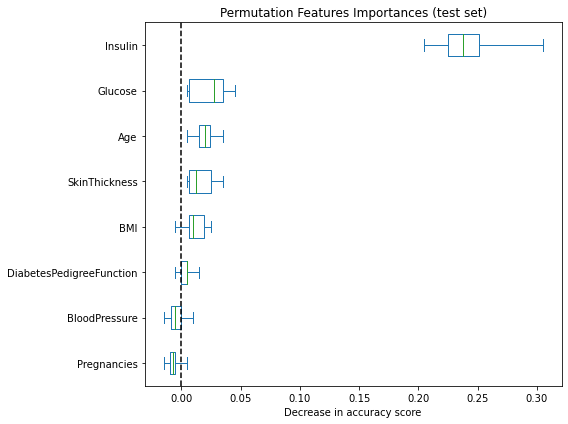

In [47]:
## Permutation Features Importances ##
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf_clf, test_set_X,test_set_Y, n_repeats=10, random_state=4011, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=x.columns[sorted_importances_idx],
)

ax = importances.plot.box(vert=False, whis=10,figsize=(8, 6))
ax.set_title("Permutation Features Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

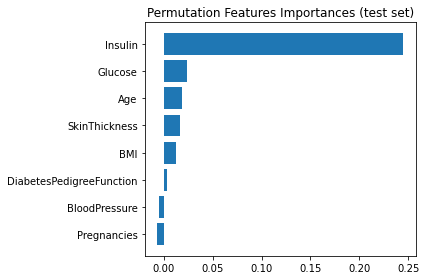

In [48]:
##Permutation Features Importances by Mean #
sorted_idx = result.importances_mean.argsort() #mean

fig, ax = plt.subplots()
ax.barh(x.columns[sorted_idx], result.importances[sorted_idx].mean(axis=1).T)
ax.set_title("Permutation Features Importances (test set)")
fig.tight_layout()
plt.show()

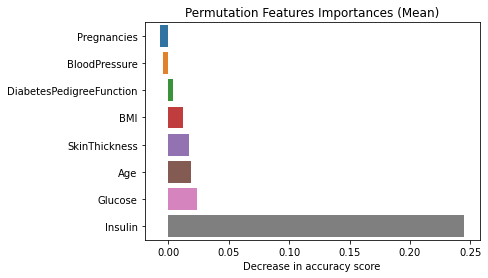

In [49]:
##Permutation Features Importances by Mean (with color)#
sorted_idx = result.importances_mean.argsort() #mean

sns.barplot(x=result.importances[sorted_idx].mean(axis=1).T, y=x.columns[sorted_idx])
plt.xlabel('Decrease in accuracy score')
plt.title("Permutation Features Importances (Mean)")
plt.show()

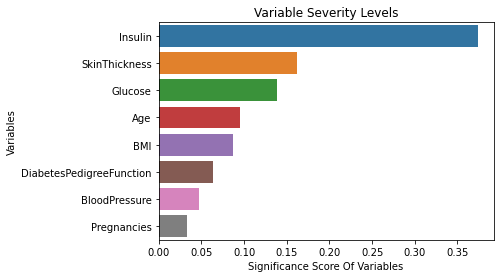

In [51]:
##Features Importances without Permutation ##
feature_imp = pd.Series(rf_clf.feature_importances_,
                        index=x.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Significance Score Of Variables')
plt.ylabel('Variables')
plt.title("Variable Severity Levels")
plt.show()

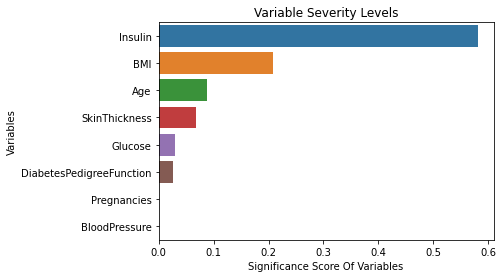

In [52]:
# DecisionTree
feature_imp = pd.Series(dt_clf.feature_importances_,
                        index=x.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Significance Score Of Variables')
plt.ylabel('Variables')
plt.title("Variable Severity Levels")
plt.show()

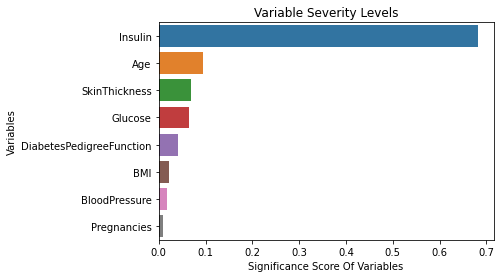

In [53]:
# XGB
feature_imp = pd.Series(xgb_tuned.feature_importances_,
                        index=x.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Significance Score Of Variables')
plt.ylabel('Variables')
plt.title("Variable Severity Levels")
plt.show()

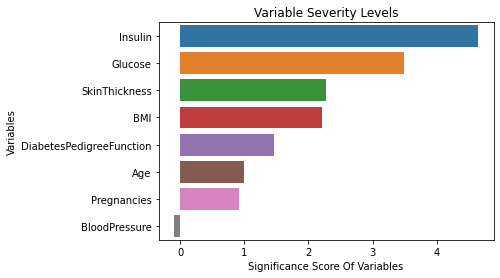

In [54]:
# LogisticRegression
feature_imp = pd.Series(log_model.fit(train_set_X, train_set_Y).coef_[0],
                        index=x.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Significance Score Of Variables')
plt.ylabel('Variables')
plt.title("Variable Severity Levels")
plt.show()